# Shrinkage Methods
* subset selection methods described before uses OLS to fit a linear model that contains a subset of predictors

* an alternative is to fit a model containing all predictors using a technique that constrains, or 'regularizes,' the coefficient estimates, or equivalently, shrinks the coefficient estimates towards zero

* previously, we wanted to find the most parsimonious model from following dataset:

In [2]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm

# download dataset and view first five observations
df = pd.read_stata('http://fmwww.bc.edu/ec-p/data/wooldridge/hprice2.dta')
df.head()

,price,crime,nox,rooms,dist,radial,proptax,stratio,lowstat,lprice,lnox,lproptax
0,24000.0,0.006,5.38,6.57,4.09,1.0,29.600000,15.300000,4.98,10.085810,1.682688,5.690360
1,21599.0,0.027,4.69,6.42,4.97,2.0,24.200001,17.799999,9.14,9.980402,1.545433,5.488938
2,34700.0,0.027,4.69,7.18,4.97,2.0,24.200001,17.799999,4.03,10.454500,1.545433,5.488938
3,33400.0,0.032,4.58,7.00,6.06,3.0,22.200001,18.700001,2.94,10.416310,1.521699,5.402678
4,36199.0,0.069,4.58,7.15,6.06,3.0,22.200001,18.700001,5.33,10.496790,1.521699,5.402678


* in the best, forward, and backward subset search, we found the best model to be the following:

$ lprice = \beta_0 + \beta_1 lnox + \beta_2 lproptax + \beta_3 crime + \beta_4 rooms + \beta_5 dist + \beta_6 radial + \beta_7 stratio + \beta_8 lowstat + e$

* this model, however, excludes the possibility of interaction terms among predictors

* consider a most completel potential model with all possible cross-products among regressors after they're recentered at mean

$ lprice = \beta_0 + \beta_1 lnox + \beta_2 lproptax + \beta_3 crime + \beta_4 rooms + \beta_5 dist + \beta_6 radial + \beta_7 stratio + \beta_8 lowstat + \beta_9 (lnox - u_{lnox})(crime - u_{crime}) + \beta_10 (lnox-u_{lnox})(crime - u_{crime}) + \dots + \beta_35 (radial-u_{radial})(lowstat - u_{lowstat}) + \beta_36 (stratio-u_{stratio})(lowstat - u_{lowstat}) + e$

* this model has 4x more regressors than the original number of predictors

* $\beta_2$ := constant elasticity of home prices with respect to property tax at meal value


In [3]:
# add all cross-products among demeaned set of predictors to original data frame
variables = ['lnox','lproptax','crime','rooms','dist','radial','stratio','lowstat']
for x in variables:
    df[x+'_dmean'] = df[x] - df[x].mean(skipna = True)
print(list(df))

['price', 'crime', 'nox', 'rooms', 'dist', 'radial', 'proptax', 'stratio', 'lowstat', 'lprice', 'lnox', 'lproptax', 'lnox_dmean', 'lproptax_dmean', 'crime_dmean', 'rooms_dmean', 'dist_dmean', 'radial_dmean', 'stratio_dmean', 'lowstat_dmean']


In [40]:
# want to get rid of plus at end

# make the interaction terms
var_str = []
for x in range(len(variables)):
    for y in variables[x+1:]:
        if x != y:
            var_str.append(variables[x] + '_dmean:' + y + '_dmean')
    
# make specifications str
f1 = 'lprice ~ 1 + ' + ''.join([ x + ' + ' for x in variables])[:-2]
f2 = f1 + ' + ' + ' '.join([x+' + ' for x in var_str])[:-2]

# print specifications strings
print('Model 1')
print(f1)
print('Model 2')
print(f2)


Model 1
lprice ~ 1 + lnox + lproptax + crime + rooms + dist + radial + stratio + lowstat 
Model 2
lprice ~ 1 + lnox + lproptax + crime + rooms + dist + radial + stratio + lowstat  + lnox_dmean:lproptax_dmean +  lnox_dmean:crime_dmean +  lnox_dmean:rooms_dmean +  lnox_dmean:dist_dmean +  lnox_dmean:radial_dmean +  lnox_dmean:stratio_dmean +  lnox_dmean:lowstat_dmean +  lproptax_dmean:crime_dmean +  lproptax_dmean:rooms_dmean +  lproptax_dmean:dist_dmean +  lproptax_dmean:radial_dmean +  lproptax_dmean:stratio_dmean +  lproptax_dmean:lowstat_dmean +  crime_dmean:rooms_dmean +  crime_dmean:dist_dmean +  crime_dmean:radial_dmean +  crime_dmean:stratio_dmean +  crime_dmean:lowstat_dmean +  rooms_dmean:dist_dmean +  rooms_dmean:radial_dmean +  rooms_dmean:stratio_dmean +  rooms_dmean:lowstat_dmean +  dist_dmean:radial_dmean +  dist_dmean:stratio_dmean +  dist_dmean:lowstat_dmean +  radial_dmean:stratio_dmean +  radial_dmean:lowstat_dmean +  stratio_dmean:lowstat_dmean 


In [41]:
# create design matrices
y1, X1 = patsy.dmatrices(f1, data=df, return_type='dataframe')
y2, X2 = patsy.dmatrices(f2, data=df, return_type='dataframe')

# create the indices for the train (80%) and validation (20%) data sets.
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

## Ridge Regression

* traditional motivation: reduce degree of collinearity among regressors

* modern motivation: regularization of high-dimensional and ill-posed inverse problems

### traditional motivation

* take linear regression model; in machine learning applications, the dimension of $\mathcal{B}$ can be very large; oftern regressors are highly correlated

* in these cases, the least squares estimator may be undefined or not reliable

* as a numerical solution to this problem, Hoerl and Kennard came up with the ridge regression

* ridge regression can be calculated even when the number of regressors exceeds the sample size

### modern motivation

* based on penalization; to deal with ill-posed estimators, use technique called regularization with leading method called penalization

* use ridge regression so that regularized least squares estimator equals ridge regression

* shows that ridge regression estimator minimizes the sum of squared errors subject to a penalty on the magnitude of the regression coefficient

* penalizing large coefficient vectors keep latter from being too large and erratic; hence on interpretation of $\lambda$ is the degree of penalty on the magnitude of the coefficient vector

(skipped visualization and its description)

* in the following, the ridge estimators are calculated for a sequence of values of $\lambda$ and observe their performance

In [42]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

# in function, alphas = lambdas from explanation 
# generate an array of alpha values ranging from very big to very small to cover the full range of scenarios from the null model, containing only the intercept, to the least squares fit:
alphas = np.linspace(0,4,20)
alphas

array([0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
       1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
       2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
       3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ])

Text(0, 0.5, 'lnox')

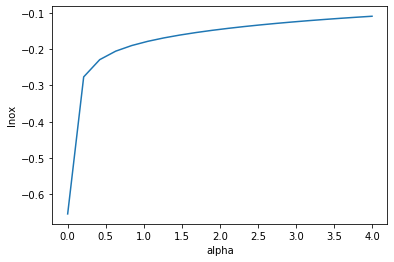

In [45]:
# create ridge object
ridge = Ridge(normalize = True)

# initialize an empty list
coefs = []

# create model fit subject to the alpha constraint
for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X2, y2)
    coefs.append(ridge.coef_)

coefs = pd.DataFrame(np.array(coefs).transpose(2,0,1).reshape(37,-1))

# expect the coefficient estimates to be much smaller when a large value of alpha is used, as compared to when a small value of alpha is used (???)
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(alphas, coefs.iloc[1])
plt.xlabel('alpha')
plt.ylabel(np.array(list(X2))[1])

In [46]:
# fit a ridge regression model on the training set, and evaluate its MSE on the test set, using alpha = 4
ridge2 = Ridge(alpha = 4, normalize = True)
# Fit a ridge regression on the training data
ridge2.fit(X2_train, y2_train)
# Use this model to predict the test data
pred2 = ridge2.predict(X2_test)
# Print coefficients
print(pd.Series(np.array(ridge2.coef_).transpose(1,0).tolist(), index = X2_train.columns))
# Calculate the test MSE
print(mean_squared_error(y2_test, pred2))

Intercept                                           [0.0]
lnox                               [-0.10613291756126295]
lproptax                           [-0.05104647277189864]
crime                            [-0.0016574298374417247]
rooms                               [0.05297148138632675]
dist                               [0.005765475217210535]
radial                           [-0.0015485729602595787]
stratio                           [-0.010009636400189982]
lowstat                            [-0.00588115769846627]
lnox_dmean:lproptax_dmean          [-0.10176823432642351]
lnox_dmean:crime_dmean            [-0.006055940715619552]
lnox_dmean:rooms_dmean            [-0.028368136825441967]
lnox_dmean:dist_dmean              [0.007121372417401316]
lnox_dmean:radial_dmean           [-0.003376212672148351]
lnox_dmean:stratio_dmean           [0.004257507181079394]
lnox_dmean:lowstat_dmean          [-0.008941600663460956]
lproptax_dmean:crime_dmean         [-0.00218446347223573]
lproptax_dmean

* instead of arbitrarily using $\lambda = 4$, would be better to use cross-validation to choose the tuning parameter alpha

* can do this using cross-validated ridge regression function: RidgeCV()

* by default, function performs generalized cross-validation (efficient form of LOOCV) but this can be changed using the cv argument

In [47]:
ridgecv = RidgeCV(alphas = alphas+0.01, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X2_train, y2_train)
ridgecv.alpha_

0.01

* the value of alpha that results in the smallest cross-validation error is 0.01

* What is the test MSE associated with this value of alpha?

In [48]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X2_train, y2_train)
mean_squared_error(y2_test, ridge4.predict(X2_test))

0.025685967549355638

In [49]:
ridge4.fit(X2, y2)
# Print coefficients
print(pd.Series(np.array(ridge4.coef_).transpose(1,0).tolist(), index = X2.columns))

Intercept                                          [0.0]
lnox                                [-0.563771905428807]
lproptax                          [-0.17629677933998594]
crime                           [-0.0012306403268748302]
rooms                               [0.1419004838240861]
dist                               [-0.0490045608797827]
radial                           [0.0075292411513011364]
stratio                          [-0.023278791158860085]
lowstat                          [-0.026431939428549257]
lnox_dmean:lproptax_dmean           [0.6154601749295747]
lnox_dmean:crime_dmean            [-0.07047994874262674]
lnox_dmean:rooms_dmean             [0.09005261426822299]
lnox_dmean:dist_dmean           [-0.0008568900692208702]
lnox_dmean:radial_dmean          [-0.012996065469773688]
lnox_dmean:stratio_dmean          [0.009447235044104971]
lnox_dmean:lowstat_dmean         [-0.015802827709742354]
lproptax_dmean:crime_dmean        [0.008518741300793364]
lproptax_dmean:rooms_dmean     

* none of the coefficients are exactly zero

* ridge regression does not perform variable selection

* disadvantage of the ridge regression: it will include all the predictors in the final model

* Ridge regression shrinks the coefficients towards zero, but it will not set any of them exactly to zero.

## Lasso Regression

* lasso stands for Least Absolute Shrinkage and Selection Operator

* shrinks the regression coefficient towards zero by penalizing the regression model with a penalty

(skipped visualization and its explanation)

* in these commands the LASSO estimators are calculated for a sequence of values of $\lambda$ and we observe their performance

* use the Lasso() function to fit lasso model

* this time the argument max_iter = 10000 is included

* Other than that change, we proceed just as we did in fitting a ridge model

In [50]:
from sklearn.preprocessing import scale 
from sklearn.linear_model import Lasso, LassoCV

lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

alphas = np.linspace(0.1,5,20)
for a in alphas:
    lasso.set_params(alpha=a,fit_intercept=False)
    lasso.fit(X2_train, y2_train)
    coefs.append(lasso.coef_)

coefs = pd.DataFrame(np.array(coefs).transpose())

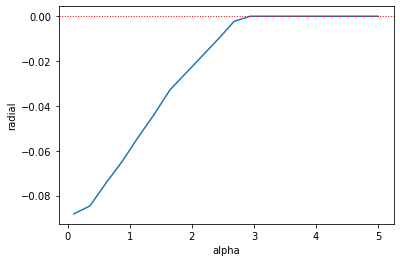

In [51]:
ax = plt.gca()
ax.plot(alphas, coefs.iloc[6])
plt.xlabel('alpha')
plt.ylabel(np.array(list(X2_train))[6])
plt.axhline(y=0,linewidth=1, color='r',linestyle=':')

* in the coefficient plot, depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero

* we'll now perform 10-fold cross-validation to choose the best $\lambda$, refit the model, and compute the associated test error:

In [54]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.set_params(fit_intercept=False)
# need .ravel() to avoid warning
lassocv.fit(X2_train, y2_train.values.ravel())

lasso.set_params(alpha=lassocv.alpha_,fit_intercept=False)
# need .ravel() to avoid warning
lasso.fit(X2_train, y2_train.values.ravel())
mean_squared_error(y2_test, lasso.predict(X2_test))

0.09345130200929799

In [55]:
# Print coefficients
print(pd.Series(lasso.fit(X2_train, y2_train).coef_.tolist(), index = X2_train.columns))

Intercept                       0.000000
lnox                            0.000000
lproptax                        0.000000
crime                          -0.000000
rooms                           0.000000
dist                            0.000000
radial                         -0.081293
stratio                         0.591753
lowstat                        -0.019226
lnox_dmean:lproptax_dmean      -0.000000
lnox_dmean:crime_dmean         -0.000000
lnox_dmean:rooms_dmean         -0.000000
lnox_dmean:dist_dmean          -0.000000
lnox_dmean:radial_dmean        -0.000000
lnox_dmean:stratio_dmean       -0.000000
lnox_dmean:lowstat_dmean        0.000000
lproptax_dmean:crime_dmean      0.000000
lproptax_dmean:rooms_dmean     -0.000000
lproptax_dmean:dist_dmean       0.000000
lproptax_dmean:radial_dmean    -0.000000
lproptax_dmean:stratio_dmean   -0.000000
lproptax_dmean:lowstat_dmean   -0.000000
crime_dmean:rooms_dmean        -0.000000
crime_dmean:dist_dmean         -0.000000
crime_dmean:radi

In [56]:
### OLS vs Ridge vs LASSO: A Special Case (skipped section)


## Elastic Net

* Since the two procedures both have advantages it seems reasonable that further improvements can be obtained by taking a compromise between the two

Selecting the Tuning Parameters

* Typically the parameters $(\alpha,\lambda)$ are selected by joint minimization of the $k$-fold cross-validation criterion.

In [57]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0.2, l1_ratio=0.7) #alpha corresponds to lambda and l1_ratio to alpha in (17)
y2_pred_enet = enet.fit(X2_train, y2_train).predict(X2_test)

mean_squared_error(y2_test, enet.predict(X2_test))

0.037089940864304796

In [60]:
from sklearn.linear_model import ElasticNetCV
enetcv = ElasticNetCV(cv=5, random_state=42,fit_intercept=False,normalize = True)
enetcv.fit(X2_train, y2_train.values.ravel()) # need .ravel() to avoid warning
print(enetcv.alpha_) # printing the chosen hyperparameter
print(enetcv.l1_ratio) # printing the chosen hyperparameter

0.8896459807769973
0.5


In [59]:
mean_squared_error(y2_test, enetcv.predict(X2_test))

0.10236877956351144